### importation de libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

import os
import seaborn as sns
import cv2

from tensorflow.keras.utils import to_categorical

print(tf.__version__)

2.13.0


In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

### Importation des données
recupération de chemin de données d'entrainement et de test

In [3]:
TRAIN_DIR = r'dataset\train'
IMG_SIZE = 32

### Créattion de fonction :

In [4]:
# cette fonction permet de recuperer les images dans le dossier
def get_data(class_name, dir):
    dataSet = []
    
    for name in class_name:
        path = os.path.join(dir, name)
        
        path_img = os.listdir(path) # chargement des images
        label = class_name.index(name) # chargement de label
        
        for img in path_img:
            
            img_array = cv2.imread(os.path.join(path, img))
            new_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            
            dataSet.append([new_img_array, label])
            
    return dataSet

In [5]:
#cette fonction permet de cinder la dataset en matrice X(pixel des images) et vecteur y
def get_X_y(data):
    X, y = [],[]
    
    for variable, label in data :
        X.append(variable)
        y.append(label)
        
    return X, y

In [6]:
#Classe de type de cancer de prostate
class_name = ['adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma', 'normal']

In [7]:
data = get_data(class_name, TRAIN_DIR) #recuperation des images

X, y = get_X_y(data) #recuperation de matrice des images X et vecteur y

### Analyse exploratoire de données

In [8]:
np.array(X).shape

(613, 32, 32, 3)

La matrice X est un tableau qui contient 613 images, dont chaque image à une taille de 32x32 tridimensionnelle(l'image est colorée (R, V, B)

##### Affichage aléatoire de quelque images

In [9]:
def visualiser_images(images, class_name, y_predict, nb_images = 16, nb_row = 4, is_random = True):

    plt.figure(figsize=(15, 15))
    for i in range(nb_images):
        
        index = i
        if(is_random):
            index = np.random.randint(len(X)) #recuperation des indices aléatoire
            
        img = X[index]

        plt.subplot(nb_row, nb_row, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(class_name[y_predict[index]])

    plt.show()

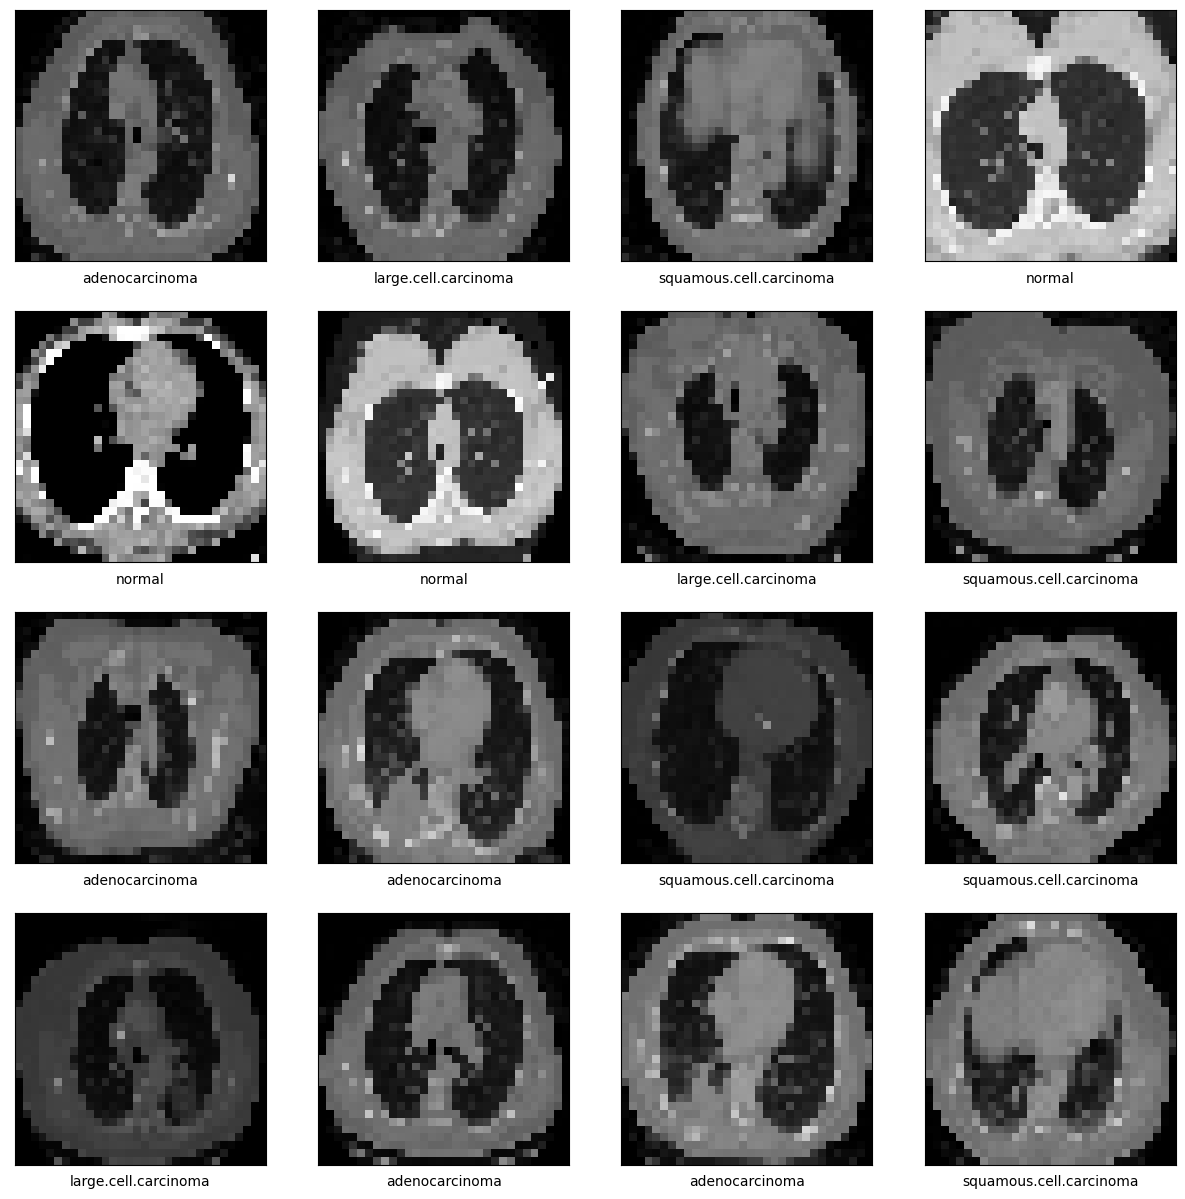

In [10]:
visualiser_images(X, class_name, y) #Appel fonction de visualisation des images

(array([195.,   0.,   0., 115.,   0.,   0., 155.,   0.,   0., 148.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

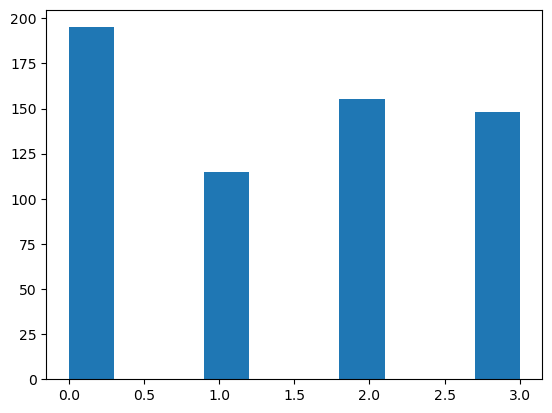

In [11]:
plt.hist(y) #Affichage d'Histogramme de vecteur y

In [12]:
y   #Affichage de vecteur y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


### Recupération de données  d'entraînement (training set) et de validation (valid set)

In [13]:
VALIDATE_DIR = r'dataset\validation' #Récuperation de chemin des images de validation

In [14]:
X_train = tf.cast(X, tf.float32) #Conversion en float
X_train /= 255.0 #Normalisation des images
y_train = to_categorical(y, len(class_name)) # Codification de classe de sortie

data_valid = get_data(class_name, VALIDATE_DIR) #Recuperation des images de validation
X_valid, y_valid = get_X_y(data_valid) #Recuperation de X et y

y_test = y_valid #Copie de vecteur y_valid avant codification

X_valid = tf.cast(X_valid, tf.float32)
X_valid /= 255.0 #Normalisation des images
y_valid = to_categorical(y_valid, len(class_name)) # Codification de label

In [15]:
X_train.shape

TensorShape([613, 32, 32, 3])

La matrice X_train est un tableau qui contient 613 images, dont chaque image à une taille de 32x32 tridimensionnelle(l'image est colorée (R, V, B)

In [16]:
y_train.shape

(613, 4)

Le y_train est un tableau qui contient 613 lignes et 4 colonnes

In [17]:
X_valid.shape

TensorShape([72, 32, 32, 3])

La matrice X_valid est un tableau qui contient 72 images, dont chaque image à une taille de 32x32 tridimensionnelle(l'image est colorée (R, V, B)

### Création du modèle

Construction du Reseau de neurone à convolution

In [18]:
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [19]:
# Variables
INPUT_SHAPE = (32, 32, 3) #Taille images d'entrées
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3, 3)
POOL_SHAPE = (2, 2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = len(class_name)

In [20]:
model = Sequential()
model.add(Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation='relu'))
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Flatten())
model.add(Dense(FULLY_CONNECT_NUM, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

### Entrainement du modele 
    a. Compilation du model

In [22]:
from tensorflow.keras.metrics import Precision, Recall

BATCH_SIZE = 32 #Taille image
EPOCHS = 50 #Nombre d'iteraction

METRICS = metrics=['accuracy',Precision(name='precision'), Recall(name='recall')]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = METRICS)

    b. Entrainement du modele

In [23]:
# Train the model
training_history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_data=(X_valid, y_valid))

Epoch 1/50
20/20 [==============================] - 5s 77ms/step - loss: 1.3018 - accuracy: 0.3736 - precision: 0.8448 - recall: 0.0799 - val_loss: 1.2904 - val_accuracy: 0.3750 - val_precision: 0.8750 - val_recall: 0.0972
Epoch 2/50
20/20 [==============================] - 1s 47ms/step - loss: 1.1196 - accuracy: 0.4845 - precision: 0.6717 - recall: 0.2170 - val_loss: 1.1314 - val_accuracy: 0.5139 - val_precision: 0.7778 - val_recall: 0.0972
Epoch 3/50
20/20 [==============================] - 1s 42ms/step - loss: 0.9296 - accuracy: 0.6215 - precision: 0.8106 - recall: 0.3002 - val_loss: 1.0419 - val_accuracy: 0.4861 - val_precision: 0.7436 - val_recall: 0.4028
Epoch 4/50
20/20 [==============================] - 1s 44ms/step - loss: 0.6676 - accuracy: 0.7357 - precision: 0.8209 - recall: 0.5905 - val_loss: 0.8715 - val_accuracy: 0.5833 - val_precision: 0.6167 - val_recall: 0.5139
Epoch 5/50
20/20 [==============================] - 1s 44ms/step - loss: 0.5344 - accuracy: 0.7961 - precisi

Epoch 38/50
20/20 [==============================] - 1s 47ms/step - loss: 0.0195 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - val_loss: 0.5934 - val_accuracy: 0.7917 - val_precision: 0.8028 - val_recall: 0.7917
Epoch 39/50
20/20 [==============================] - 1s 44ms/step - loss: 0.0145 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - val_loss: 0.7010 - val_accuracy: 0.8056 - val_precision: 0.8028 - val_recall: 0.7917
Epoch 40/50
20/20 [==============================] - 1s 44ms/step - loss: 0.0245 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - val_loss: 0.7152 - val_accuracy: 0.7361 - val_precision: 0.7465 - val_recall: 0.7361
Epoch 41/50
20/20 [==============================] - 1s 43ms/step - loss: 0.0165 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - val_loss: 0.5970 - val_accuracy: 0.7917 - val_precision: 0.7887 - val_recall: 0.7778
Epoch 42/50
20/20 [==============================] - 1s 43ms/step - loss: 0.0208 - accuracy: 0.9951 - pr

### Courbe de la fonction d'erreur et de la precision

In [24]:
def plot_learning_curve(history, epoch):
    epoch_range = range(1, epoch + 1)
    
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Précision du modèle')
    plt.ylabel('Model')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left') 
    plt.show()
    
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Perte de modèle')
    plt.ylabel('Model')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')   
    plt.show()

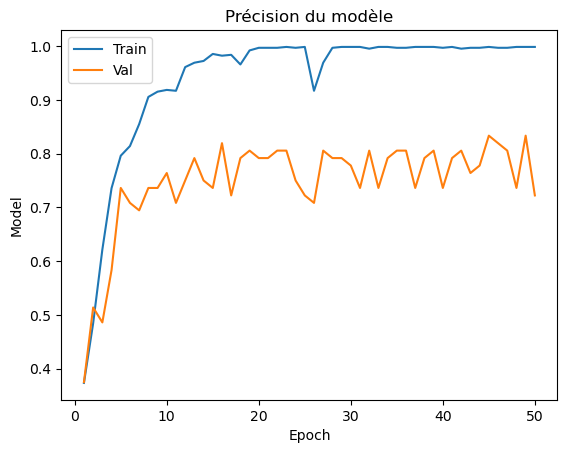

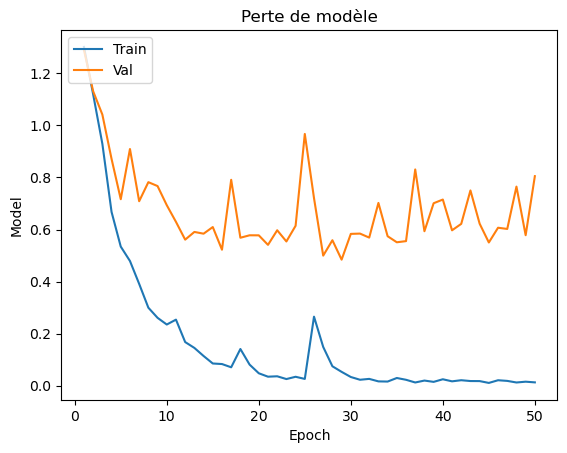

In [25]:
plot_learning_curve(training_history, EPOCHS) #Appel fonction

#### Evaluation du modele

In [26]:
score = model.evaluate(X_valid, y_valid)

print('\nTest Loss : ', score[0])
print("Accuracy : %.2f%% " % (score[1]*100))
print('Test Precision : ', score[1])

3/3 [==============================] - 0s 11ms/step - loss: 0.8051 - accuracy: 0.7222 - precision: 0.7222 - recall: 0.7222

Test Loss :  0.8050872087478638
Accuracy : 72.22% 
Test Precision :  0.7222222089767456


#### Matrice de confusion

3/3 [==============================] - 0s 8ms/step


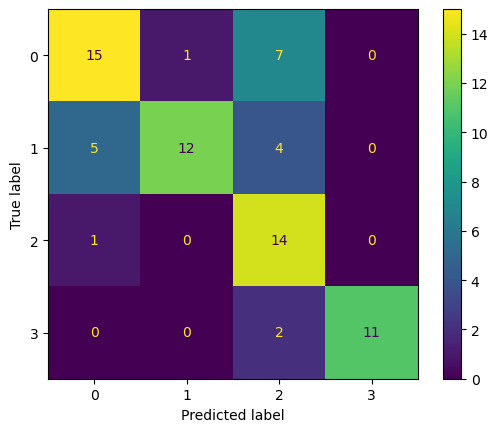

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_predict = model.predict(X_valid)

y_test_predict = np.argmax(y_test_predict, axis=1)

cm = confusion_matrix(y_test, y_test_predict)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

La matrice de confusion evalue la performance du modele.
  nous avons y et y_predict, les nombres des images qui appartener à une classe dont le modele les a predit dans la même classe
    ou le modele à commis d'erreur

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68        23
           1       0.92      0.57      0.71        21
           2       0.52      0.93      0.67        15
           3       1.00      0.85      0.92        13

    accuracy                           0.72        72
   macro avg       0.79      0.75      0.74        72
weighted avg       0.79      0.72      0.73        72



### Prédiction de nouvel image

In [29]:
#cette fonction recupère la matrice de pixel des images (X)
def get_X(dir):
    X = []
    
    path = dir
    path_img = os.listdir(path)
    
    for img in path_img:

        img_array = cv2.imread(os.path.join(path, img))
        new_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        X.append(new_img_array)
        
    return X

In [30]:
TEST_DIR = r'dataset\test_data' #Recuperation du chemin de données de test

X_new = get_X(TEST_DIR)
img_new = X_new

In [31]:
X_new = tf.cast(X_new, tf.float32)
X_new /= 255.0                        #Normalisation de la matrice des images

In [32]:
X_new.shape

TensorShape([16, 32, 32, 3])

La matrice X_new est un tableau qui contient 16 images, dont chaque image à une taille de 32x32 tridimensionnelle(l'image est colorée (R, V, B)

In [33]:
y_predict = np.argmax(model.predict(X_new),axis=1) # prediction de classe des images

1/1 [==============================] - 0s 41ms/step


In [34]:
y_predict.shape

(16,)

In [35]:
y_predict

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3], dtype=int64)

1/1 [==============================] - 0s 29ms/step


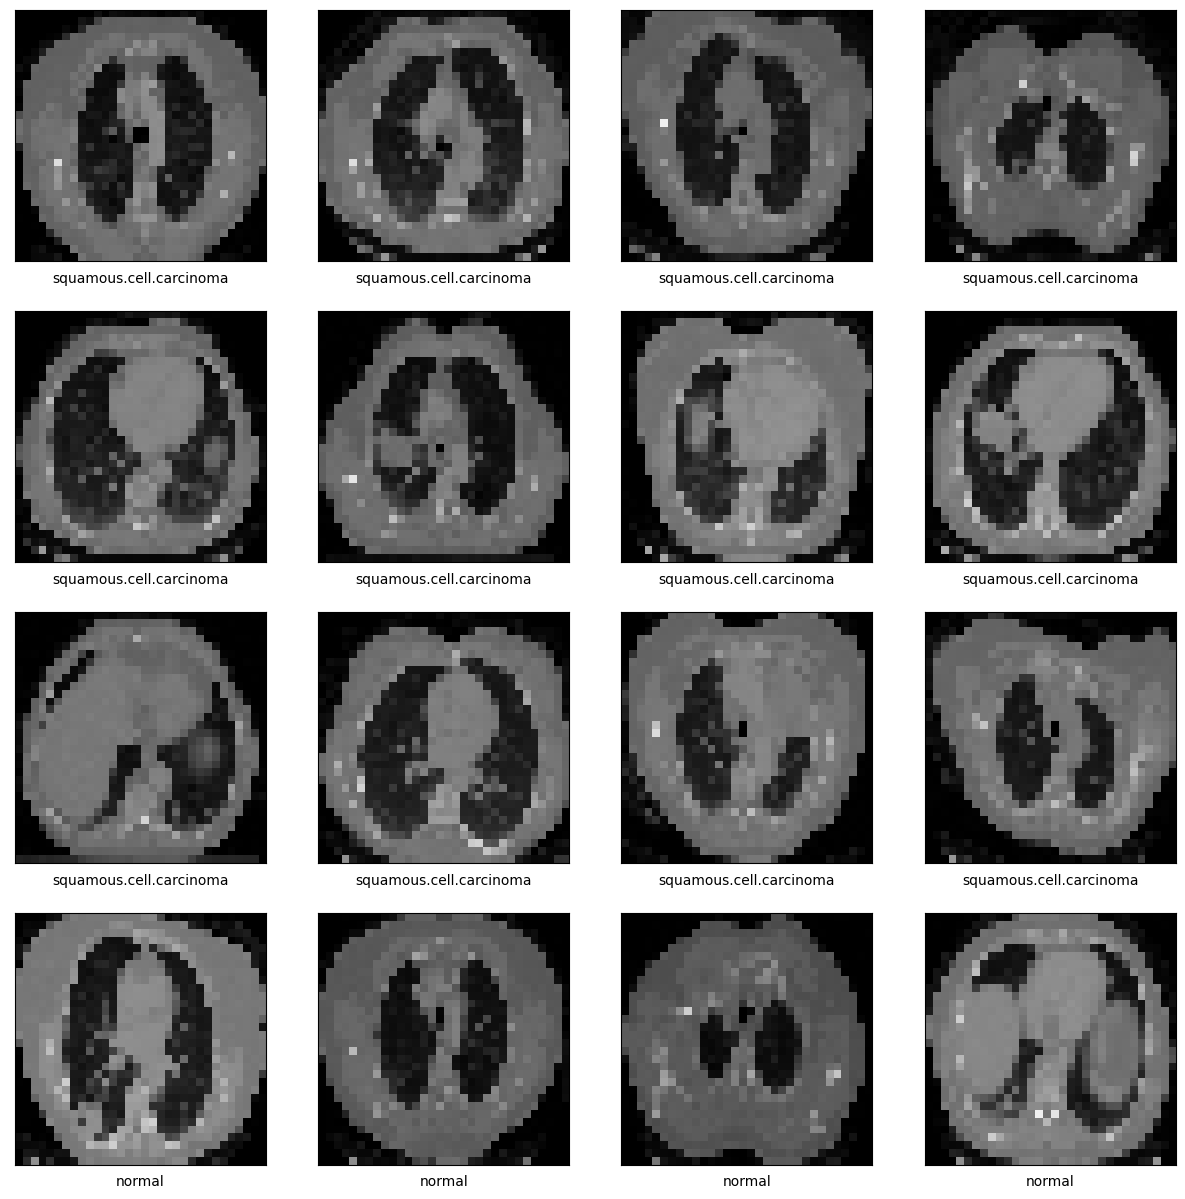

In [36]:
nb_images = len(model.predict(X_new))
visualiser_images(img_new, class_name, y_predict, nb_images, 4, False) #4 nombre de ligne et colonne d'affichage

In [37]:
import ipywidgets as widgets
from PIL import Image
from IPython.display import display,clear_output
import io

In [38]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(IMG_SIZE,IMG_SIZE))
    img = img.reshape(1,IMG_SIZE,IMG_SIZE,3)
    X_new = img
    img = tf.cast(img, tf.float32)
    img /= 255.0
    predict = np.argmax(model.predict(img), axis=1)[0]
    if predict == 0:
        y_predict = class_name[0]
    elif predict == 1:
        y_predict = class_name[1]
    elif predict == 2:
        y_predict = class_name[2]
    elif predict == 3:
        y_predict = class_name[3]

    print(f'La prediction :\n********************************************')
    if predict >= 0:
        plt.figure(figsize=(5, 5))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(y_predict)
        plt.imshow(opencvImage, cmap=plt.cm.binary)
        plt.show()

In [44]:
uploader = widgets.FileUpload()
display(uploader) #Variable uploader recupère l'image séléctionnée

FileUpload(value={}, description='Upload')

In [45]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader) #Appel de fonction de prediction
            
        except:
            print('No Image Uploaded/Invalid Image File')
            
button.on_click(on_button_clicked)
widgets.VBox([button,out])